In [246]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../names.txt', 'r').read().splitlines()

In [289]:
chars = sorted(list(set(''.join(words))))

chtoi = {ch:i+1 for i,ch in enumerate(chars)}
chtoi['.'] = 0
itoch = {i:ch for ch,i in chtoi.items()}
print(itoch)
print(chtoi)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [76]:
# build input values.

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:2]:
  
  context = [0] * block_size
  for ch in w + '.':
    ix = chtoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itoch[i] for i in context), '--->', itoch[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)
print(X, Y)
print(X.shape, X.dtype, Y.shape, Y.dtype)


tensor([[ 0,  0,  0],
        [ 0,  0, 14],
        [ 0, 14, 25],
        [14, 25, 18],
        [25, 18,  5],
        [18,  5,  5],
        [ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5,  4],
        [ 5,  4,  9],
        [ 4,  9,  5]]) tensor([14, 25, 18,  5,  5,  0,  5,  4,  9,  5,  0])
torch.Size([11, 3]) torch.int64 torch.Size([11]) torch.int64


In [38]:
def build_dataset(words):
    X = []
    Y = []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = chtoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    return torch.tensor(X), torch.tensor(Y)
    

# build training set, dev set, test set. - 80%, 10%, 10% each
import random
random.seed(42) #seed
random.shuffle(words) #shuffle to get random values and no bias.
n = len(words)
n1 = int(0.8 * n)
n2 = int(0.9 * n)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])
print(Xtr.shape, Xdev.shape, Xtest.shape)

torch.Size([182424, 3]) torch.Size([22836, 3]) torch.Size([22886, 3])


In [45]:
C = torch.randn((27, 2)) # mapping input values in 2 dimensions. Bengio paper maps 17000 words into 30 dimensions.
# try maping to 3 or more dimensions and test.
C.shape, X.shape

(torch.Size([27, 2]), torch.Size([67, 3]))

In [56]:
C[X].shape # Embedding X into C.
# this represents

print(C[5]) # 5th item in C
F.one_hot(torch.tensor(5), num_classes=27).float() @ C # 5th item bit is on and is multiplied by c, we will get the same as C[5]

print(X[13, 2].item())
print(C[X][13, 2], C[15]) # both values are same


tensor([0.7499, 0.3564])
15
tensor([-1.2245,  0.0621]) tensor([-1.2245,  0.0621])


In [99]:
#C[X] = [ [[x10, x20], [x11, x21], [x12, x22]] ...] 67 rows containing 3 columns containing 2 values. these values are repititive based on labels.
# if you change the C dimension here that C[X] will change accordingly.
# next layer neurons will take 3x2 values as input work accordingly.
# To scale things, we are going flatten the 3x2 values as flat 6 values but keep the indices intact.
#Why do we need this? - This is to solve any orbitary dimension input values as list, so that neurons layer code is scalable.
# we can still pass 2x3 values as input to next layer but we will have to work and write code which is much more complex.
# How do we flatten these values? In normal code,
example = [ [ [1, 2], [3, 4], [5, 6] ],
            [ [7, 8], [9, 10], [11, 12] ],
          ]
allrows = []
for characters in example:
    flattenembedding = []
    for embeddings in characters:
        for embedding in embeddings:
            flattenembedding.append(embedding)
    allrows.append(flattenembedding)
print(allrows)

# Is there a way to do it in pytorch?

# we can try using torch functions the same way.
torchex = torch.tensor(example)
print(torch.unbind(torchex, 1))
print(torch.cat(torch.unbind(torchex, 1))) # this is one way to do in pytorch the same as we did in the above code but it creates new instance, requires more memory.
print(torchex.view(2, 6)) # this is the efficient way to do it.

# try with our input.
emb = C[X]
print(emb.shape)
#emb[:, 0, :]
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1) # this is same as 
print(torch.cat(torch.unbind(emb, 1), 1))
print(emb.view(11, 6))

[[1, 2, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12]]
(tensor([[1, 2],
        [7, 8]]), tensor([[ 3,  4],
        [ 9, 10]]), tensor([[ 5,  6],
        [11, 12]]))
tensor([[ 1,  2],
        [ 7,  8],
        [ 3,  4],
        [ 9, 10],
        [ 5,  6],
        [11, 12]])
tensor([[ 1,  2,  3,  4,  5,  6],
        [ 7,  8,  9, 10, 11, 12]])
torch.Size([11, 3, 2])
tensor([[ 0.0715,  0.5508,  0.0715,  0.5508,  0.0715,  0.5508],
        [ 0.0715,  0.5508,  0.0715,  0.5508,  0.6123, -0.1099],
        [ 0.0715,  0.5508,  0.6123, -0.1099,  0.3652,  0.4494],
        [ 0.6123, -0.1099,  0.3652,  0.4494, -1.2600, -1.2229],
        [ 0.3652,  0.4494, -1.2600, -1.2229,  0.7499,  0.3564],
        [-1.2600, -1.2229,  0.7499,  0.3564,  0.7499,  0.3564],
        [ 0.0715,  0.5508,  0.0715,  0.5508,  0.0715,  0.5508],
        [ 0.0715,  0.5508,  0.0715,  0.5508,  0.7499,  0.3564],
        [ 0.0715,  0.5508,  0.7499,  0.3564, -0.7617,  1.3623],
        [ 0.7499,  0.3564, -0.7617,  1.3623, -0.4534, -1.0895],
    

In [136]:
# we have 2 embeddings and 3 of them for each input. so the next layer should take 6 values as input.
emb = C[X]
W = torch.randn(6, 100) # 100 neurons
b = torch.randn(100) # 100 neuron biases.
h1 = emb.view(emb.shape[0], 6) @ W + b
h2 = emb.view(-1, 6) @ W + b # pytorch will infer this value

h = torch.tanh(emb.view (-1, 6) @ W + b)
h.shape

W2 = torch.randn(100, 27)
b2 = torch.randn(27)

logits = h @ W2 + b2

In [142]:
counts = logits.exp()
probs = counts /counts.sum(1, keepdims=True)

print(probs)
print(Y)
#print(probs[[0, 0], [0, 2]])
probs[torch.arange(11), Y] # these values represent the [x][y] - x is ith input (x=i) y is the output label in the training set.
#ideally we would want to reduce this gap.

# probs represent that output values with probabilities.
print(-probs[torch.arange(11), Y].log().mean()) # loss function

entropy = F.cross_entropy(logits, Y)
print(entropy) # the loss function that we have created using counts & probs and cross_entropy should be same
#cross_entropuy provides more stable values and handles normalization
# exp values for higher positivie values may not fit in float point.
# to solve this pytorch normalizes them and substract the max value. addition or substraction of any value won't change the distribution.
tt = torch.tensor([-3, 5, 0, 4])
tt2 = torch. tensor([-30, 6, 2, 100])
ttcounts = tt.exp()
tt2counts = tt2.exp()
ttcounts, tt2counts # you can see tt2counts value becomes inf.

tensor([[6.4331e-08, 1.0612e-05, 6.1910e-02, 6.2168e-08, 3.7669e-12, 2.1499e-05,
         8.4913e-01, 4.5372e-05, 2.5787e-07, 3.3424e-09, 1.8407e-07, 3.2267e-07,
         2.3247e-06, 3.0867e-10, 4.2198e-10, 6.6296e-08, 2.2400e-05, 1.9782e-08,
         1.8559e-04, 8.9540e-11, 4.3236e-09, 3.2114e-04, 2.5693e-02, 6.2655e-02,
         6.0844e-07, 4.4409e-11, 3.1391e-08],
        [2.8683e-13, 4.7890e-08, 7.2447e-05, 1.7255e-11, 1.1583e-10, 6.1642e-10,
         9.9991e-01, 2.0739e-09, 1.1278e-09, 1.3817e-11, 5.6296e-08, 1.4794e-08,
         6.8889e-08, 1.3790e-12, 2.4714e-12, 1.1036e-11, 4.2884e-11, 1.7643e-10,
         1.0202e-06, 5.5486e-11, 4.9532e-12, 5.5174e-07, 1.4967e-05, 9.4978e-08,
         1.3893e-09, 8.7464e-14, 7.2014e-12],
        [1.1590e-09, 1.6072e-07, 3.0674e-04, 1.1320e-09, 3.2366e-11, 7.7514e-09,
         1.0582e-03, 4.1932e-09, 9.6594e-09, 1.3313e-07, 9.3541e-08, 4.3722e-08,
         1.3703e-12, 5.9384e-15, 7.1076e-13, 4.0916e-08, 1.5743e-07, 4.3158e-10,
         1.8722e-

(tensor([4.9787e-02, 1.4841e+02, 1.0000e+00, 5.4598e+01]),
 tensor([9.3576e-14, 4.0343e+02, 7.3891e+00,        inf]))

In [273]:
# Given X dataset, build parameters and model.
# C, W1, b1, W2, b2
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g) # addition adds extra dimension padding.
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad= True
print(sum([p.nelement() for p in parameters])) # total number of parameters.

3481


In [183]:
x_input = Xtr
y_input = Ytr
for i in range(10): #run the gradient descent 10 times to fit the data.
    # forward pass
    emb = C[x_input]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_input)
    print(loss.item()) # printing loss value.

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update based on gradient descent.
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

2.830526113510132
2.823349952697754
2.8171072006225586
2.8116259574890137
2.806772470474243
2.802438974380493
2.798539161682129
2.7950050830841064
2.7917792797088623
2.7888171672821045
2.7888171672821045


In [224]:
x_input = Xtr
y_input = Ytr
for i in range(1000): #run the gradient descent 10 times to fit the data.
    # forward pass
    batchidx = torch.randint(0, x_input.shape[0], (32,)) # generate 32 input values from input randomly.
    x_input_batch = x_input[batchidx]
    y_input_batch = y_input[batchidx]
    emb = C[x_input_batch]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_input_batch)
    #print(loss.item()) # printing loss value.

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update based on gradient descent.
    for p in parameters:
        p.data += -0.1 * p.grad #learning rate. how do we determine this value?
print(loss.item())

2.434597969055176


In [266]:
lre = torch.linspace(-3, 0, 10000) # learning rate exponents.
lrs = 10**lre #learning rate steps. starting from 0.001 to 1.

In [280]:
x_input = Xtr
y_input = Ytr

lri = []
lrei = []
lossi = []
stepi = []
for i in range(10000): #run the gradient descent 10 times to fit the data.
    # forward pass
    batchidx = torch.randint(0, x_input.shape[0], (32,)) # generate 32 input values from input randomly.
    x_input_batch = x_input[batchidx]
    y_input_batch = y_input[batchidx]
    emb = C[x_input_batch]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_input_batch)
    #print(loss.item()) # printing loss value.

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update based on gradient descent.    
    for p in parameters:
        p.data += -lrs[i] * p.grad #learning rate. how do we determine this value?
    lri.append(lrs[i])
    lrei.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)

print(loss.item())

2.251359462738037


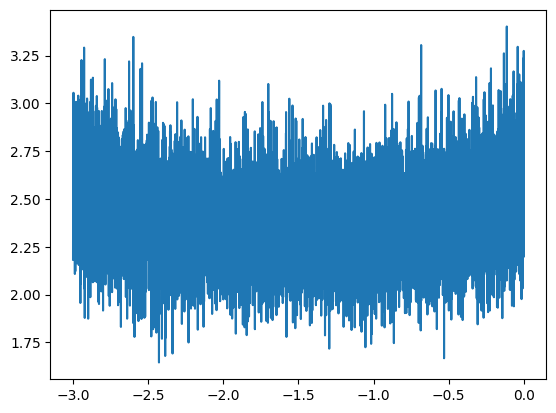

In [281]:
plt.plot(lrei, lossi)

In [282]:
# calculate loss
def calculate_loss(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss

training_loss = calculate_loss(Xtr, Ytr)
test_loss = calculate_loss(Xtest, Ytest)
print(training_loss, test_loss)

tensor(2.6628, grad_fn=<NllLossBackward0>) tensor(2.6667, grad_fn=<NllLossBackward0>)


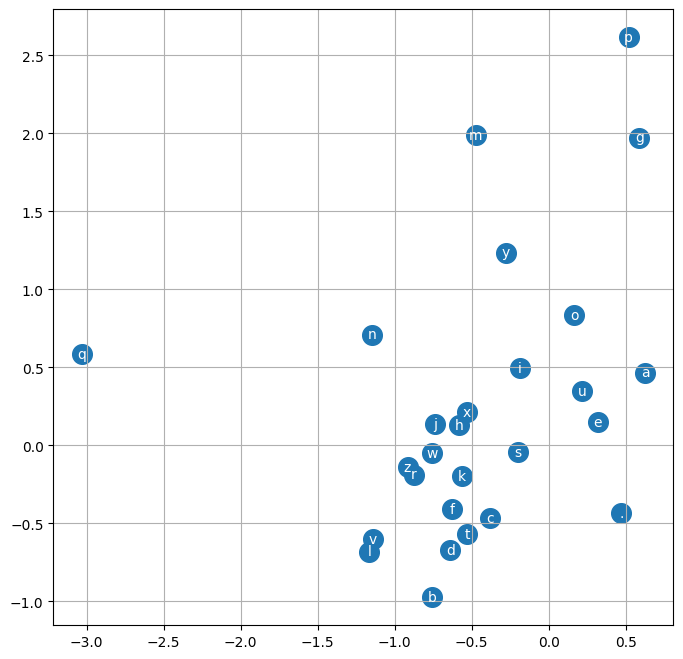

In [283]:
#plot the figures
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoch[i], ha="center", va="center", color='white')
plt.grid('minor')

In [298]:
g = torch.Generator().manual_seed(2147483647)
def predict_next(X, Y):
    idx = 0;
    out = []
    context = [0] * block_size
    # if you set the generator here, you will ge the samevalue again and again.
    while True:
        emb = C[torch.tensor([context])] #c[index]
        h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        if idx == 0:
            return ''.join(out)
        out.append(itoch[idx])
    return ''

for i in range(20):
    predicted_name = predict_next(Xtr, Ytr)
    print(predicted_name)

jea
maidalinia
jaziayde
jilia
jna
jra
fak
kavia
jayiyabeltahryintas
milia
kavu
jeya
daria
javmassde
jakaviynyantlsn
hilinnavta
lys
jasdra
jayil
jyaw
